In [1]:
from numpy import array
import nltk
from bnlp.corpus import stopwords
from bnlp.corpus.util import remove_stopwords
from bangla_stemmer.stemmer import stemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
df_train = pd.read_csv('check/train.csv')
df_test = pd.read_csv('check/test.csv')
df_train.dropna(subset = ["data"], inplace=True) 
df_test.dropna(subset = ["data"], inplace=True) 
# df = df[df['sentiment'] != "Anger"]
df_train.dropna(subset = ["data"], inplace=True) 
df_train.dropna(subset = ["emotion"], inplace=True)
df_test.dropna(subset = ["data"], inplace=True) 
df_test.dropna(subset = ["emotion"], inplace=True) 

C:\Users\hvhjj\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
frames = [df_test,df_train]
texts= pd.concat(frames)

In [3]:
now=df_test.drop_duplicates()
now.dropna(subset = ["data"], inplace=True) 
now.dropna(subset = ["emotion"], inplace=True) 
df_test=now
df_test['emotion'].value_counts()

Insightful    1224
Curious        400
Gratitude      399
Name: emotion, dtype: int64

In [4]:
import re,string
import functools  
tokenized_lines = []
def get_clean(text):
        whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
        bangla_fullstop = u"\u0964"
        punctSeq = u"['\"“”‘’]+|[.?!,…]+|[:;]+"
        punc = u"[(),$%^&*+={}\[\]:\"|\'\~`<>/,¦!?½£¶¼©⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟↉¤¿º;-]+"
        text = whitespace.sub(" ", text).strip()
        text = re.sub(r'[^\u0980-\u09FF ]+', '', text)
        text = re.sub(punctSeq, " ", text)
        text = re.sub('\w*\d\w*','',text)
        text = re.sub(bangla_fullstop, " ", text)
        text = re.sub(punc, " ", text)
        text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', ' ', text)
        text=text.replace("\\", " ")
        tokenized_lines.append(text.split())
        return text



In [5]:
df_train['data'] = df_train['data'].apply(lambda x: get_clean(x))
df_train.dropna(subset = ["data"], inplace=True) 
df_test['data'] = df_test['data'].apply(lambda x: get_clean(x))
df_test.dropna(subset = ["data"], inplace=True) 
texts['data'] = texts['data'].apply(lambda x: get_clean(x))
texts.dropna(subset = ["data"], inplace=True) 


In [6]:
#Loading Bnwiki Data For Word3vec model
preprocessed_text_file_path='vectraindata/bnwiki-texts-preprocessed.txt'                 
lines_from_file = []
with open(preprocessed_text_file_path, encoding='utf8') as text_file:
    for line in text_file:
        lines_from_file.append(line)


for single_line in lines_from_file:
    tokenized_lines.append(single_line.split())


In [7]:
#Training Word2vec model
import gensim
word_model = gensim.models.Word2Vec(tokenized_lines,vector_size=300,min_count=1)


In [8]:
# # # df['vec'] = df['data'].apply(lambda x: get_vec(x))
# # # type(df['data'][0])
# import nlp
# import numpy as np
# def get_vec(x):
#     doc=nlp(x)
#     vec=doc.word_model.wv.get_vector
#     return vec;
def featureVecMethod(words,num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float64")
    nwords = 0
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(word_model.wv.index_to_key)
    for word in  words:
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,word_model.wv.get_vector(word))
            
                
    # Dividing the result by number of words to get average
    if nwords!=0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

def getAvgFeatureVecs(reviews,num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float64")
    for review in reviews:
        reviewFeatureVecs[counter] = featureVecMethod(review, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [9]:
import numpy as np
clean_train_reviews = []
for review in df_train['data']:
    clean_train_reviews.append(review.split())
    
X_train = getAvgFeatureVecs(clean_train_reviews, 300)
y_train = df_train['emotion']



In [23]:
.clean_test_reviews = []
for review in df_test['data']:
    clean_test_reviews.append(review.split())
X_test = getAvgFeatureVecs(clean_test_reviews, 300)
y_test = df_test['emotion']

In [8]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(trainDataVecs,y, test_size=0.2, shuffle=True)
# print(y_train.shape)
# print(y_test.shape)

(6116,)
(1530,)


In [25]:
#Rendom
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest.fit(X_train,y_train)

Fitting random forest to training data....


RandomForestClassifier()

In [24]:
df_test['data'].shape

(2023,)

In [26]:
forest.score(X_test,y_test)

0.7894216510133465

In [27]:

y_pred=forest.predict(X_test)
class_names = ['Insightful', 'Curious', 'Gratitude']
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
report = classification_report(y_test,y_pred,class_names)
print(report)

              precision    recall  f1-score   support

  Insightful       0.84      0.82      0.83      1224
     Curious       0.66      0.64      0.65       400
   Gratitude       0.76      0.85      0.81       399

    accuracy                           0.79      2023
   macro avg       0.76      0.77      0.76      2023
weighted avg       0.79      0.79      0.79      2023



In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
confusion_m = confusion_matrix(y_test,y_pred,class_names)
confusion_m

array([[999, 124, 101],
       [139, 257,   4],
       [ 52,   6, 341]], dtype=int64)

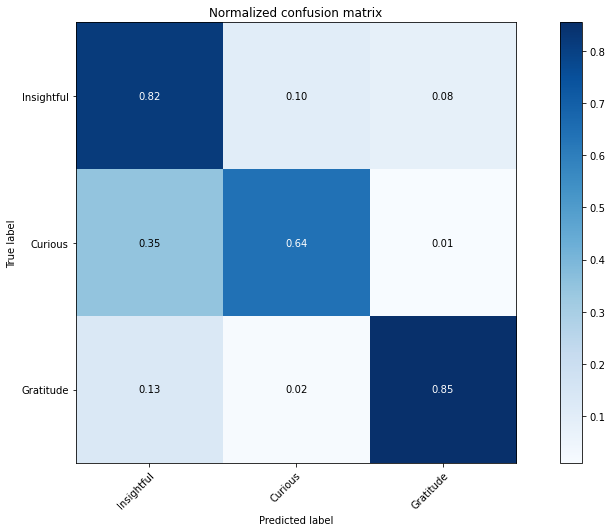

In [29]:
    title='Normalized confusion matrix'
    normalize=True
    cmap=plt.cm.Blues
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =confusion_m

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


In [30]:
forest.fit(X_test,y_test)

RandomForestClassifier()

In [31]:
forest.score(X_train,y_train)

0.5911427903715821

In [32]:

y_pred=forest.predict(X_train)
class_names = ['Insightful', 'Curious', 'Gratitude']
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
report = classification_report(y_train,y_pred,class_names)
print(report)

              precision    recall  f1-score   support

  Insightful       0.42      0.98      0.59      2576
     Curious       0.96      0.29      0.45      3149
   Gratitude       0.97      0.57      0.72      2833

    accuracy                           0.59      8558
   macro avg       0.78      0.61      0.59      8558
weighted avg       0.80      0.59      0.58      8558



In [33]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
confusion_m = confusion_matrix(y_train,y_pred,class_names)

In [34]:
confusion_m

array([[2517,   26,   33],
       [2223,  914,   12],
       [1190,   15, 1628]], dtype=int64)

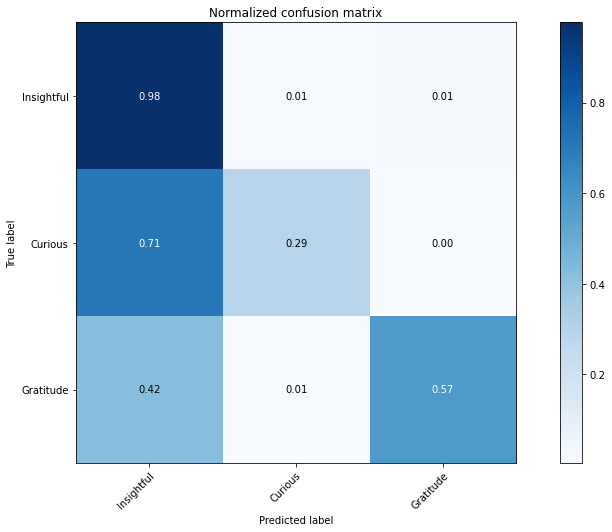

In [35]:
    title='Normalized confusion matrix'
    normalize=True
    cmap=plt.cm.Blues
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =confusion_m

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


In [39]:
# SVM
from sklearn.svm import SVC
test = SVC(kernel='linear')
test.fit(X_train,y_train)
test.score(X_test,y_test)

0.7572911517548195

In [40]:
y_pred=test.predict(X_test)
report = classification_report(y_test,y_pred,class_names)
print(report)

              precision    recall  f1-score   support

  Insightful       0.89      0.70      0.79      1224
     Curious       0.61      0.78      0.69       400
   Gratitude       0.65      0.91      0.76       399

    accuracy                           0.76      2023
   macro avg       0.72      0.80      0.74      2023
weighted avg       0.79      0.76      0.76      2023



In [41]:
confusion_m = confusion_matrix(y_test,y_pred,class_names)
confusion_m

array([[857, 186, 181],
       [ 76, 313,  11],
       [ 25,  12, 362]], dtype=int64)

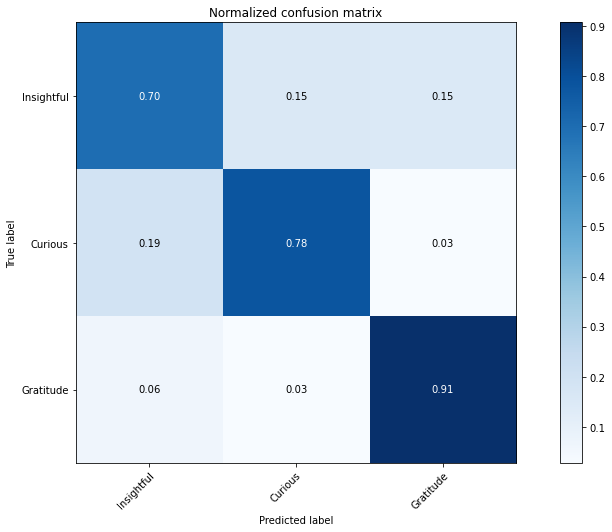

In [42]:
    title='Normalized confusion matrix'
    normalize=True
    cmap=plt.cm.Blues
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =confusion_m

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7572911517548195

In [44]:
test = SVC(kernel='linear')
test.fit(X_test,y_test)
test.score(X_train,y_train)

0.7009815377424632

In [45]:
y_pred=test.predict(X_train)
report = classification_report(y_train,y_pred,class_names)
print(report)

              precision    recall  f1-score   support

  Insightful       0.52      0.88      0.65      2576
     Curious       0.86      0.58      0.69      3149
   Gratitude       0.94      0.68      0.79      2833

    accuracy                           0.70      8558
   macro avg       0.77      0.71      0.71      8558
weighted avg       0.78      0.70      0.71      8558



In [46]:
confusion_m = confusion_matrix(y_train,y_pred,class_names)
confusion_m

array([[2275,  217,   84],
       [1296, 1811,   42],
       [ 832,   88, 1913]], dtype=int64)

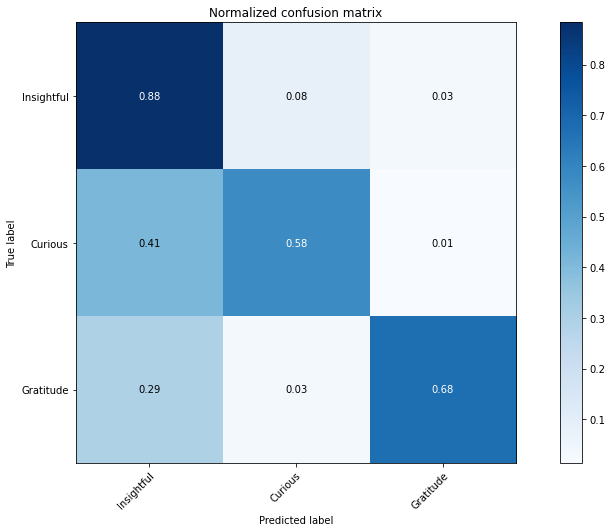

In [47]:
    title='Normalized confusion matrix'
    normalize=True
    cmap=plt.cm.Blues
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =confusion_m

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
